In [1]:
import config_cat_embedding
import numpy as np
import pandas as pd
import random
import time

from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix

from tqdm.notebook import tqdm
from data_prep import bank_data_prep, adult_data_prep
from embedding_helper import create_network

from scipy import stats  # For confidence intervals

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

def create_cooccurrence_matrix_diag(df_cat):
    # Get unique categories
    categories = np.unique(df_cat)

    # Create a dictionary to map category to index
    category_to_index = {cat: i for i, cat in enumerate(categories)}

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.itertuples(index=False):
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Calculate the diagonal values
    diagonal_values = []
    for cat in categories:
        count = df_cat.stack().value_counts()[cat]
        diagonal_values.append(count)

    # Set diagonal values to category counts
    np.fill_diagonal(matrix, diagonal_values)

    # Convert the matrix to a sparse matrix
    sparse_matrix = coo_matrix(matrix)

    # Normalize the matrix
    normalized_matrix = csr_matrix(sparse_matrix / sparse_matrix.sum(axis=1))

    # Convert to DataFrame for easier handling
    co_occurrence_matrix_norm = pd.DataFrame(normalized_matrix.toarray(), index=categories, columns=categories)

    return co_occurrence_matrix_norm

# get_embeddings function outside the loop
def get_embeddings(df, model):
    embeddings = []
    for index, row in df.iterrows():
        node_vectors = []
        for cat in row:
            if str(cat) in model.wv:
                node_vectors.append(model.wv[str(cat)])
            else:
                node_vectors.append(np.zeros(model.vector_size))
        embeddings.append(np.mean(node_vectors, axis=0))
    return np.array(embeddings)

# =============================================
# Start of the adapted code for cross-validation
# =============================================

# Load and preprocess data
data_path = config_cat_embedding.paths['data']
bank_data = pd.read_csv(data_path + 'bank-additional-full.csv', sep=';')

# Preprocess the data (you should define bank_data_prep accordingly)
df_bank, cat_cols = bank_data_prep(bank_data)

X = df_bank.iloc[:, :-1]
y = df_bank.y

# Define the classifiers
seed = 42

models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('XGB', XGBClassifier(eval_metric='logloss', random_state=seed)),
    ('MLP', KerasClassifier(
        model=create_network,
        epochs=100, batch_size=100, verbose=0, random_state=seed))
]

# Cross-validation setup
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=seed)

# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return m, m - h, m + h

# Loop over models
for name, model in models:
    print(f"Classifier: {name}")
    # Lists to store metrics for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []

    # Start the timer before cross-validation
    start_time = time.time()

    fold = 1
    for train_index, test_index in cv.split(X, y):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Preprocess data within the fold
        # Handle categorical variables
        cat_data_train = X_train_fold[cat_cols]
        cat_data_test = X_test_fold[cat_cols]

        # Create co-occurrence matrix using the training data
        co_occurrence_matrix = create_cooccurrence_matrix_diag(cat_data_train)

        # Use Node2Vec or another method to create embeddings from the co-occurrence matrix
        # Here, we will create a graph and compute embeddings
        G = nx.from_pandas_adjacency(co_occurrence_matrix)

        node2vec = Node2Vec(G, dimensions=50, walk_length=10, num_walks=20, workers=4, seed=seed)
        node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)

        # Map embeddings to the categorical data
        X_train_emb = get_embeddings(cat_data_train, node2vec_model)
        X_test_emb = get_embeddings(cat_data_test, node2vec_model)

        # If there are numerical features, include them
        num_cols = X_train_fold.drop(columns=cat_cols).columns.tolist()
        if num_cols:
            num_data_train = X_train_fold[num_cols].values
            num_data_test = X_test_fold[num_cols].values

            # Combine numerical and embedding features
            X_train_combined = np.hstack((X_train_emb, num_data_train))
            X_test_combined = np.hstack((X_test_emb, num_data_test))
        else:
            X_train_combined = X_train_emb
            X_test_combined = X_test_emb

        # Standard scaling
        stc = StandardScaler()
        X_train_scaled = stc.fit_transform(X_train_combined)
        X_test_scaled = stc.transform(X_test_combined)

        # Update number_of_features for MLP
        number_of_features = X_train_scaled.shape[1]
        if name == 'MLP':
            # Update the model with the correct number of features
            model.set_params(model__number_of_features=number_of_features)

        # Fit the model
        model.fit(X_train_scaled, y_train_fold)
        # Predict on the test fold
        y_pred_fold = model.predict(X_test_scaled)

        # Get prediction probabilities for ROC AUC
        if hasattr(model, "predict_proba"):
            y_pred_prob_fold = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # For classifiers without predict_proba, use decision_function
            y_pred_prob_fold = model.decision_function(X_test_scaled)
            # Normalize the decision function output to [0,1] range
            y_pred_prob_fold = (y_pred_prob_fold - y_pred_prob_fold.min()) / (y_pred_prob_fold.max() - y_pred_prob_fold.min())

        # Calculate metrics
        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        precisions.append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
        recalls.append(recall_score(y_test_fold, y_pred_fold))
        f1s.append(f1_score(y_test_fold, y_pred_fold))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_prob_fold))

        # print(f"Fold {fold} completed.")
        fold += 1

    # Stop the timer after cross-validation
    end_time = time.time()
    total_computation_time = end_time - start_time  # Total time for the model

    # Calculate mean and confidence intervals
    acc_mean, acc_ci_lower, acc_ci_upper = confidence_interval(accuracies)
    prec_mean, prec_ci_lower, prec_ci_upper = confidence_interval(precisions)
    rec_mean, rec_ci_lower, rec_ci_upper = confidence_interval(recalls)
    f1_mean, f1_ci_lower, f1_ci_upper = confidence_interval(f1s)
    roc_mean, roc_ci_lower, roc_ci_upper = confidence_interval(roc_aucs)

    # Print results
    print(f"Accuracy: {acc_mean:.3f} (95% CI: {acc_ci_lower:.3f} - {acc_ci_upper:.3f})")
    print(f"Precision: {prec_mean:.3f} (95% CI: {prec_ci_lower:.3f} - {prec_ci_upper:.3f})")
    print(f"Recall: {rec_mean:.3f} (95% CI: {rec_ci_lower:.3f} - {rec_ci_upper:.3f})")
    print(f"F1 Score: {f1_mean:.3f} (95% CI: {f1_ci_lower:.3f} - {f1_ci_upper:.3f})")
    print(f"ROC AUC: {roc_mean:.3f} (95% CI: {roc_ci_lower:.3f} - {roc_ci_upper:.3f})")
    print(f"Total Computation Time: {total_computation_time:.3f} seconds\n")


C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\P70071469\AppData\Local\anaconda3\envs\SLR\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Classifier: LR


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.907 (95% CI: 0.904 - 0.909)
Precision: 0.658 (95% CI: 0.639 - 0.677)
Recall: 0.359 (95% CI: 0.340 - 0.377)
F1 Score: 0.463 (95% CI: 0.445 - 0.481)
ROC AUC: 0.913 (95% CI: 0.908 - 0.918)
Total Computation Time: 201.597 seconds

Classifier: DT


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.906 (95% CI: 0.904 - 0.908)
Precision: 0.650 (95% CI: 0.632 - 0.668)
Recall: 0.358 (95% CI: 0.342 - 0.374)
F1 Score: 0.461 (95% CI: 0.445 - 0.478)
ROC AUC: 0.843 (95% CI: 0.835 - 0.850)
Total Computation Time: 204.837 seconds

Classifier: RF


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.896 (95% CI: 0.895 - 0.897)
Precision: 0.809 (95% CI: 0.778 - 0.839)
Recall: 0.099 (95% CI: 0.087 - 0.110)
F1 Score: 0.175 (95% CI: 0.156 - 0.194)
ROC AUC: 0.890 (95% CI: 0.885 - 0.895)
Total Computation Time: 666.358 seconds

Classifier: KNN


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.893 (95% CI: 0.891 - 0.894)
Precision: 0.542 (95% CI: 0.526 - 0.558)
Recall: 0.294 (95% CI: 0.279 - 0.309)
F1 Score: 0.380 (95% CI: 0.365 - 0.396)
ROC AUC: 0.740 (95% CI: 0.731 - 0.749)
Total Computation Time: 193.197 seconds

Classifier: XGB


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.905 (95% CI: 0.902 - 0.908)
Precision: 0.607 (95% CI: 0.588 - 0.625)
Recall: 0.441 (95% CI: 0.419 - 0.462)
F1 Score: 0.510 (95% CI: 0.490 - 0.530)
ROC AUC: 0.914 (95% CI: 0.909 - 0.918)
Total Computation Time: 210.338 seconds

Classifier: MLP


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.897 (95% CI: 0.895 - 0.899)
Precision: 0.559 (95% CI: 0.542 - 0.576)
Recall: 0.439 (95% CI: 0.419 - 0.459)
F1 Score: 0.490 (95% CI: 0.478 - 0.501)
ROC AUC: 0.908 (95% CI: 0.904 - 0.913)
Total Computation Time: 1966.931 seconds



In [1]:
import config_cat_embedding
import numpy as np
import pandas as pd
import random
import time

from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix

from tqdm.notebook import tqdm
from data_prep import bank_data_prep, adult_data_prep
from embedding_helper import create_network

from scipy import stats  # For confidence intervals

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

def create_cooccurrence_matrix_diag(df_cat):
    # Get unique categories
    categories = np.unique(df_cat)

    # Create a dictionary to map category to index
    category_to_index = {cat: i for i, cat in enumerate(categories)}

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.itertuples(index=False):
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Calculate the diagonal values
    diagonal_values = []
    for cat in categories:
        count = df_cat.stack().value_counts()[cat]
        diagonal_values.append(count)

    # Set diagonal values to category counts
    np.fill_diagonal(matrix, diagonal_values)

    # Convert the matrix to a sparse matrix
    sparse_matrix = coo_matrix(matrix)

    # Normalize the matrix
    normalized_matrix = csr_matrix(sparse_matrix / sparse_matrix.sum(axis=1))

    # Convert to DataFrame for easier handling
    co_occurrence_matrix_norm = pd.DataFrame(normalized_matrix.toarray(), index=categories, columns=categories)

    return co_occurrence_matrix_norm

# get_embeddings function outside the loop
def get_embeddings(df, model):
    embeddings = []
    for index, row in df.iterrows():
        node_vectors = []
        for cat in row:
            if str(cat) in model.wv:
                node_vectors.append(model.wv[str(cat)])
            else:
                node_vectors.append(np.zeros(model.vector_size))
        embeddings.append(np.mean(node_vectors, axis=0))
    return np.array(embeddings)

# =============================================
# Start of the adapted code for cross-validation
# =============================================

# Load and preprocess data
data_path = config_cat_embedding.paths['data']
bank_data = pd.read_csv(data_path + 'bank-additional-full.csv', sep=';')

# Preprocess the data (you should define bank_data_prep accordingly)
df_bank, cat_cols = bank_data_prep(bank_data)

X = df_bank.iloc[:, :-1]
y = df_bank.y

# Define the classifiers
seed = 42

models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('XGB', XGBClassifier(eval_metric='logloss', random_state=seed)),
    ('MLP', KerasClassifier(
        model=create_network,
        epochs=100, batch_size=100, verbose=0, random_state=seed))
]

# Cross-validation setup
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=seed)

# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return m, m - h, m + h

# Loop over models
for name, model in models:
    print(f"Classifier: {name}")
    # Lists to store metrics for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []

    # Start the timer before cross-validation
    start_time = time.time()

    fold = 1
    for train_index, test_index in cv.split(X, y):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Preprocess data within the fold
        # Handle categorical variables
        cat_data_train = X_train_fold[cat_cols]
        cat_data_test = X_test_fold[cat_cols]

        # Create co-occurrence matrix using the training data
        co_occurrence_matrix = create_cooccurrence_matrix_diag(cat_data_train)

        # Use Node2Vec or another method to create embeddings from the co-occurrence matrix
        # Here, we will create a graph and compute embeddings
        G = nx.from_pandas_adjacency(co_occurrence_matrix)

        node2vec = Node2Vec(G, dimensions=30, walk_length=30, num_walks=10, workers=4, seed=seed)
        node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)

        # Map embeddings to the categorical data
        X_train_emb = get_embeddings(cat_data_train, node2vec_model)
        X_test_emb = get_embeddings(cat_data_test, node2vec_model)

        # If there are numerical features, include them
        num_cols = X_train_fold.drop(columns=cat_cols).columns.tolist()
        if num_cols:
            num_data_train = X_train_fold[num_cols].values
            num_data_test = X_test_fold[num_cols].values

            # Combine numerical and embedding features
            X_train_combined = np.hstack((X_train_emb, num_data_train))
            X_test_combined = np.hstack((X_test_emb, num_data_test))
        else:
            X_train_combined = X_train_emb
            X_test_combined = X_test_emb

        # Standard scaling
        stc = StandardScaler()
        X_train_scaled = stc.fit_transform(X_train_combined)
        X_test_scaled = stc.transform(X_test_combined)

        # Update number_of_features for MLP
        number_of_features = X_train_scaled.shape[1]
        if name == 'MLP':
            # Update the model with the correct number of features
            model.set_params(model__number_of_features=number_of_features)

        # Fit the model
        model.fit(X_train_scaled, y_train_fold)
        # Predict on the test fold
        y_pred_fold = model.predict(X_test_scaled)

        # Get prediction probabilities for ROC AUC
        if hasattr(model, "predict_proba"):
            y_pred_prob_fold = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # For classifiers without predict_proba, use decision_function
            y_pred_prob_fold = model.decision_function(X_test_scaled)
            # Normalize the decision function output to [0,1] range
            y_pred_prob_fold = (y_pred_prob_fold - y_pred_prob_fold.min()) / (y_pred_prob_fold.max() - y_pred_prob_fold.min())

        # Calculate metrics
        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        precisions.append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
        recalls.append(recall_score(y_test_fold, y_pred_fold))
        f1s.append(f1_score(y_test_fold, y_pred_fold))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_prob_fold))

        # print(f"Fold {fold} completed.")
        fold += 1

    # Stop the timer after cross-validation
    end_time = time.time()
    total_computation_time = end_time - start_time  # Total time for the model

    # Calculate mean and confidence intervals
    acc_mean, acc_ci_lower, acc_ci_upper = confidence_interval(accuracies)
    prec_mean, prec_ci_lower, prec_ci_upper = confidence_interval(precisions)
    rec_mean, rec_ci_lower, rec_ci_upper = confidence_interval(recalls)
    f1_mean, f1_ci_lower, f1_ci_upper = confidence_interval(f1s)
    roc_mean, roc_ci_lower, roc_ci_upper = confidence_interval(roc_aucs)

    # Print results
    print(f"Accuracy: {acc_mean:.3f} (95% CI: {acc_ci_lower:.3f} - {acc_ci_upper:.3f})")
    print(f"Precision: {prec_mean:.3f} (95% CI: {prec_ci_lower:.3f} - {prec_ci_upper:.3f})")
    print(f"Recall: {rec_mean:.3f} (95% CI: {rec_ci_lower:.3f} - {rec_ci_upper:.3f})")
    print(f"F1 Score: {f1_mean:.3f} (95% CI: {f1_ci_lower:.3f} - {f1_ci_upper:.3f})")
    print(f"ROC AUC: {roc_mean:.3f} (95% CI: {roc_ci_lower:.3f} - {roc_ci_upper:.3f})")
    print(f"Total Computation Time: {total_computation_time:.3f} seconds\n")


Classifier: LR


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.906 (95% CI: 0.904 - 0.908)
Precision: 0.655 (95% CI: 0.636 - 0.674)
Recall: 0.347 (95% CI: 0.331 - 0.363)
F1 Score: 0.453 (95% CI: 0.436 - 0.470)
ROC AUC: 0.906 (95% CI: 0.901 - 0.911)
Total Computation Time: 244.964 seconds

Classifier: DT


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.906 (95% CI: 0.904 - 0.908)
Precision: 0.650 (95% CI: 0.632 - 0.668)
Recall: 0.358 (95% CI: 0.342 - 0.374)
F1 Score: 0.461 (95% CI: 0.445 - 0.478)
ROC AUC: 0.842 (95% CI: 0.835 - 0.849)
Total Computation Time: 283.498 seconds

Classifier: RF


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.897 (95% CI: 0.895 - 0.898)
Precision: 0.801 (95% CI: 0.770 - 0.833)
Recall: 0.110 (95% CI: 0.097 - 0.122)
F1 Score: 0.192 (95% CI: 0.173 - 0.212)
ROC AUC: 0.886 (95% CI: 0.881 - 0.892)
Total Computation Time: 591.078 seconds

Classifier: KNN


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.894 (95% CI: 0.891 - 0.896)
Precision: 0.549 (95% CI: 0.531 - 0.566)
Recall: 0.314 (95% CI: 0.297 - 0.332)
F1 Score: 0.399 (95% CI: 0.381 - 0.417)
ROC AUC: 0.753 (95% CI: 0.743 - 0.763)
Total Computation Time: 251.815 seconds

Classifier: XGB


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.903 (95% CI: 0.901 - 0.906)
Precision: 0.596 (95% CI: 0.581 - 0.612)
Recall: 0.434 (95% CI: 0.416 - 0.451)
F1 Score: 0.501 (95% CI: 0.486 - 0.517)
ROC AUC: 0.912 (95% CI: 0.908 - 0.916)
Total Computation Time: 205.504 seconds

Classifier: MLP


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Accuracy: 0.900 (95% CI: 0.897 - 0.904)
Precision: 0.580 (95% CI: 0.556 - 0.603)
Recall: 0.439 (95% CI: 0.420 - 0.459)
F1 Score: 0.498 (95% CI: 0.482 - 0.515)
ROC AUC: 0.909 (95% CI: 0.904 - 0.914)
Total Computation Time: 1878.769 seconds



In [1]:
import config_cat_embedding
import numpy as np
import pandas as pd
import random
import time

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_auc_score
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix

from tqdm import tqdm_notebook as tqdm
from data_prep import bank_data_prep
from embedding_helper import create_network

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

def create_cooccurrence_matrix_diag(df_cat):
    # Get unique categories
    categories = np.unique(df_cat)

    # Create a dictionary to map category to index
    category_to_index = {cat: i for i, cat in enumerate(categories)}

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.itertuples(index=False):
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Calculate the diagonal values
    diagonal_values = []
    for cat in categories:
        count = df_cat.stack().value_counts()[cat]
        diagonal_values.append(count)

    # Calculate co-occurrence matrix
    matrix = np.zeros((len(categories), len(categories)))
    for row in df_cat.values:
        for i, cat1 in enumerate(row):
            for j, cat2 in enumerate(row):
                if i != j:
                    matrix[category_to_index[cat1], category_to_index[cat2]] += 1

    # Set diagonal values to category counts
    np.fill_diagonal(matrix, diagonal_values)

    # Convert the matrix to a sparse matrix
    sparse_matrix = coo_matrix(matrix)

    # Normalize the matrix
    normalized_matrix = csr_matrix(sparse_matrix / sparse_matrix.sum(axis=1))

    # Print the normalized matrix
   # print(normalized_matrix.toarray())

    # Print the matrix with row and column labels
    co_occurrence_matrix_norm = pd.DataFrame(normalized_matrix.toarray(), index=categories, columns=categories)
    #print(co_occurrence_matrix_norm)
    return co_occurrence_matrix_norm




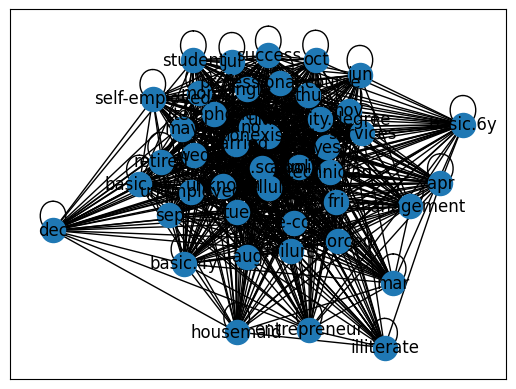

In [2]:
# Load the data and complete the data pre-processing
data_path = config_cat_embedding.paths['data']
data_path_out = config_cat_embedding.paths['data_output']
bank_data = pd.read_csv(data_path + 'bank-additional-full.csv', sep=';')

dat_bank, cat_cols = bank_data_prep(bank_data)

X = dat_bank.iloc[:, :-1]
target = dat_bank.y

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=1500)
X_train_cat = X_train[cat_cols]

co_occurrence_matrix_norm = create_cooccurrence_matrix_diag(X_train_cat)

categories = np.unique(X_train_cat)

# Build the graph
graph = nx.from_numpy_array(co_occurrence_matrix_norm.values)

# Set the layout for the visualization
pos = nx.spring_layout(graph)

# Draw the nodes and edges
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_edges(graph, pos)

# Add labels for the nodes
labels = {i: categories[i] for i in range(len(categories))}
nx.draw_networkx_labels(graph, pos, labels)

# Display the visualization
plt.show()



In [3]:
# Generate node2vec embeddings
node2vec = Node2Vec(graph, dimensions=30, walk_length=30, num_walks=10)
model = node2vec.fit(window=10, min_count=1)
model.save("node2vec.model.bank")

# Get the vocabulary
vocabulary = model.wv.index_to_key
print("Vocabulary: ", vocabulary)

# Create a dictionary to map category to index
category_to_index = {cat: i for i, cat in enumerate(categories)}
category_to_index

cat2vec = {}
for i in range(len(categories)):
    cat2vec[categories[i]] = model.wv[model.wv.index_to_key[i]]
    
cat2vec

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 10/10 [00:00<00:00, 140.85it/s]

Vocabulary:  ['23', '7', '24', '20', '36', '37', '32', '41', '13', '35', '43', '21', '27', '40', '38', '42', '0', '12', '25', '28', '22', '30', '31', '33', '39', '34', '29', '6', '11', '16', '26', '9', '5', '3', '2', '17', '19', '18', '15', '1', '14', '10', '8', '4']


{'admin.': array([-0.32300377,  0.05355858,  0.5520876 ,  0.00808737, -0.02157714,
        -0.03616333, -0.00745006,  0.10700499, -0.3407889 , -0.11256903,
         0.12746482, -0.02349862, -0.02957859, -0.23080026, -0.02921377,
        -0.27580965,  0.10947858,  0.05184115, -0.31738883, -0.06627129,
         0.15985376, -0.07838798, -0.05758762,  0.25780043,  0.20716502,
         0.08423071,  0.30546668,  0.26154274, -0.17156081, -0.41249946],
       dtype=float32),
 'apr': array([-0.42367935,  0.05104844,  0.63403624, -0.06327459, -0.01241615,
        -0.01122407,  0.02909229,  0.07031772, -0.2519781 , -0.08918539,
         0.06124468,  0.04432788, -0.05945424, -0.28268418, -0.10348296,
        -0.3125742 ,  0.07349849,  0.05472609, -0.23988178, -0.00252019,
         0.08518278, -0.04152798, -0.05331353,  0.30204198,  0.17983156,
         0.11341942,  0.3324368 ,  0.22156873, -0.18884398, -0.2925338 ],
       dtype=float32),
 'aug': array([-0.34441346,  0.06501077,  0.5546518 , -0.04

In [4]:
dimpool = 30
elements = []
for row in tqdm(X_train.iterrows()):
    categorical_embeddings = []
    for i in cat_cols:
        try:
            categorical_embeddings.append(cat2vec[row[1][i]])
        except:
            categorical_embeddings.append(np.zeros((dimpool)))
    elements.append(np.array(categorical_embeddings))
#elements 
reshaped_x = (np.reshape(elements,(len(elements),len(cat_cols)*dimpool)))   
# Get the numerical columns
numerical_cols = np.where(X_train.dtypes!="object")[0]
my_data = pd.concat([X_train.iloc[:, numerical_cols].reset_index(drop=True), pd.DataFrame(reshaped_x)], axis=1)
# due to the new index of my_data, we have to change the index of y_train
y_train = y_train.reset_index(drop=True)


C:\Users\xg16060\AppData\Local\Temp\1\ipykernel_17332\3506753142.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm(X_train.iterrows()):


0it [00:00, ?it/s]

In [5]:
np.shape(reshaped_x)

(32950, 300)

In [6]:
X.shape

(41188, 15)

In [7]:

#%% apply it on the X_test dataset 
elements_test = []
for row in tqdm(X_test.iterrows()):
    categorical_embeddings = []
    for i in cat_cols:
        #print(i,row[1][i])
        try:
            categorical_embeddings.append(cat2vec[row[1][i]])
        except:
            categorical_embeddings.append(np.zeros((dimpool)))
    elements_test .append(np.array(categorical_embeddings))

#elements 
reshaped_x_test = (np.reshape(elements_test ,(len(elements_test ),len(cat_cols)*dimpool)))   
# Get the numerical columns
my_test_data = pd.concat([X_test.iloc[:, numerical_cols].reset_index(drop=True), pd.DataFrame(reshaped_x_test)], axis=1)
# due to the new index of my_data, we have to change the index of y_train
y_test = y_test.reset_index(drop=True)

C:\Users\xg16060\AppData\Local\Temp\1\ipykernel_17332\2029421698.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm(X_test.iterrows()):


0it [00:00, ?it/s]

In [8]:
my_test_data.head(3)

,age,duration,campaign,pdays,previous,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,32,216,1,999,0,-0.380584,0.072246,0.594518,-0.028618,0.008958,-0.008750,0.010357,0.067688,-0.271056,-0.106881,0.112524,-0.025678,-0.014792,-0.294712,-0.047196,-0.263487,0.106303,0.009495,-0.285847,-0.001271,0.100508,-0.047078,-0.087060,0.282488,0.208425,0.155276,0.285930,0.256789,-0.182804,-0.341251,-0.379363,0.084492,0.623247,-0.033963,-0.026085,-0.015235,-0.010149,0.062568,-0.273366,-0.10178,0.094285,0.029444,-0.060963,-0.306598,-0.051182,-0.316989,0.106311,0.007308,-0.229233,-0.022766,0.128146,-0.09072,-0.07217,0.322971,0.18334,0.088432,0.28085,0.253811,-0.151137,-0.324293,-0.387663,0.062013,0.578938,-0.026766,0.004827,-0.016443,-0.012645,0.061624,-0.287719,-0.105123,0.094026,0.000836,-0.032030,-0.257234,-0.089381,-0.272976,0.102165,0.019415,-0.295220,-0.014507,0.125616,-0.049931,-0.078530,0.285129,0.179479,0.088150,0.304888,0.257590,-0.158833,-0.399527,-0.348486,0.06302,0.565523,-0.019373,-0.013475,0.002209,0.039461,0.087549,-0.297966,-0.07859,0.148577,-0.024577,0.012434,-0.23319,-0.058051,-0.266853,0.104949,-0.001224,-0.287776,-0.062648,0.103089,-0.046807,-0.046136,0.276813,0.182795,0.124256,0.315446,0.247479,-0.194542,-0.414462,-0.338094,0.057189,0.625595,-0.064413,0.011004,0.016084,0.028192,0.129963,-0.264135,-0.047807,0.061989,0.046330,-0.060303,-0.295259,-0.063698,-0.304725,0.056842,-0.026298,-0.254717,-0.037150,0.107960,-0.053776,-0.108327,0.261806,0.217935,0.160016,0.324317,0.261033,-0.150576,-0.391216,-0.348486,0.063020,0.565523,-0.019373,-0.013475,0.002209,0.039461,0.087549,-0.297966,-0.078590,0.148577,-0.024577,0.012434,-0.233190,-0.058051,-0.266853,0.104949,-0.001224,-0.287776,-0.062648,0.103089,-0.046807,-0.046136,0.276813,0.182795,0.124256,0.315446,0.247479,-0.194542,-0.414462,-0.359928,0.057163,0.604573,-0.005245,0.063604,-0.028355,0.028145,0.176740,-0.297289,-0.102578,0.054948,-0.020953,-0.058503,-0.287085,0.023518,-0.294245,0.119878,0.059321,-0.269832,0.009846,0.144342,-0.107043,-0.106840,0.255891,0.135692,0.130749,0.298807,0.273407,-0.138689,-0.358636,-0.318993,0.098419,0.561501,-0.002862,-0.019667,-0.005553,-0.041750,0.058162,-0.303344,-0.124267,0.132562,-0.043920,0.008578,-0.277156,-0.045065,-0.257998,0.067306,-0.002524,-0.299107,-0.022832,0.131627,-0.098389,-0.106738,0.276118,0.179340,0.088248,0.298495,0.210995,-0.16256,-0.409408,-0.326879,0.063085,0.560207,-0.017153,0.002242,-0.024001,-0.009739,0.068106,-0.322391,-0.111061,0.129106,-0.047476,0.014688,-0.288610,-0.102933,-0.280086,0.058814,0.040789,-0.256727,-0.044787,0.117501,-0.060139,-0.059955,0.282618,0.168286,0.117291,0.318744,0.246703,-0.207292,-0.406485,-0.330417,0.073192,0.572741,-0.072457,-0.032759,0.036342,-0.019009,0.116142,-0.320428,-0.048544,0.096765,-0.007261,-0.007171,-0.309087,-0.077009,-0.275742,0.071543,0.009187,-0.280872,-0.039994,0.164529,-0.060304,-0.080112,0.28668,0.225746,0.110918,0.277426,0.232322,-0.136826,-0.383728
1,21

In [9]:
import time
X_train2, X_test2, y_train2, y_test2 = train_test_split(my_data,y_train,test_size=0.2, random_state=1500)
stc = StandardScaler()
X_scaled = stc.fit_transform(X_train2.values)

In [10]:
X_train2.head(3)

,age,duration,campaign,pdays,previous,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
15234,45,290,1,999,0,-0.323004,0.053559,0.552088,0.008087,-0.021577,-0.036163,-0.00745,0.107005,-0.340789,-0.112569,0.127465,-0.023499,-0.029579,-0.2308,-0.029214,-0.27581,0.109479,0.051841,-0.317389,-0.066271,0.159854,-0.078388,-0.057588,0.2578,0.207165,0.084231,0.305467,0.261543,-0.171561,-0.412499,-0.320912,0.033452,0.583443,-0.025378,0.003415,0.017780,0.029929,0.096292,-0.323473,-0.083064,0.118198,0.013211,-0.017397,-0.244643,-0.046013,-0.280713,0.132307,0.053209,-0.264600,-0.054889,0.118062,-0.077795,-0.047211,0.290041,0.194323,0.129149,0.310494,0.216333,-0.165955,-0.394155,-0.387663,0.062013,0.578938,-0.026766,0.004827,-0.016443,-0.012645,0.061624,-0.287719,-0.105123,0.094026,0.000836,-0.032030,-0.257234,-0.089381,-0.272976,0.102165,0.019415,-0.295220,-0.014507,0.125616,-0.049931,-0.078530,0.285129,0.179479,0.08815,0.304888,0.25759,-0.158833,-0.399527,-0.348486,0.06302,0.565523,-0.019373,-0.013475,0.002209,0.039461,0.087549,-0.297966,-0.07859,0.148577,-0.024577,0.012434,-0.23319,-0.058051,-0.266853,0.104949,-0.001224,-0.287776,-0.062648,0.103089,-0.046807,-0.046136,0.276813,0.182795,0.124256,0.315446,0.247479,-0.194542,-0.414462,-0.348486,0.06302,0.565523,-0.019373,-0.013475,0.002209,0.039461,0.087549,-0.297966,-0.07859,0.148577,-0.024577,0.012434,-0.23319,-0.058051,-0.266853,0.104949,-0.001224,-0.287776,-0.062648,0.103089,-0.046807,-0.046136,0.276813,0.182795,0.124256,0.315446,0.247479,-0.194542,-0.414462,-0.348486,0.06302,0.565523,-0.019373,-0.013475,0.002209,0.039461,0.087549,-0.297966,-0.07859,0.148577,-0.024577,0.012434,-0.23319,-0.058051,-0.266853,0.104949,-0.001224,-0.287776,-0.062648,0.103089,-0.046807,-0.046136,0.276813,0.182795,0.124256,0.315446,0.247479,-0.194542,-0.414462,-0.355828,0.092770,0.613367,0.022130,-0.081025,0.015144,-0.015429,0.085794,-0.266083,-0.054961,0.170980,0.022745,-0.003545,-0.242689,-0.112676,-0.264395,0.114125,-0.029832,-0.223256,-0.061508,0.153001,0.006685,-0.052705,0.291491,0.158719,0.087794,0.302405,0.259662,-0.194249,-0.372125,-0.377481,0.059649,0.567811,-0.037162,-0.011987,-0.047520,-0.042176,0.096089,-0.286464,-0.085087,0.093497,-0.020013,0.021738,-0.228397,-0.095727,-0.291814,0.091486,0.001694,-0.283408,-0.002398,0.167548,-0.085136,-0.090336,0.238657,0.195099,0.153780,0.332618,0.263286,-0.135530,-0.404602,-0.33194,0.047162,0.569678,-0.004799,-0.01682,0.024107,-0.026486,0.06239,-0.309542,-0.10032,0.10023,-0.001973,-0.024497,-0.253815,-0.020489,-0.291017,0.112709,0.03422,-0.274897,0.01137,0.13317,-0.089376,-0.097769,0.282404,0.193031,0.09335,0.327553,0.206154,-0.166986,-0.37634,-0.330417,0.073192,0.572741,-0.072457,-0.032759,0.036342,-0.019009,0.116142,-0.320428,-0.048544,0.096765,-0.007261,-0.007171,-0.309087,-0.077009,-0.275742,0.071543,0.009187,-0.280872,-0.039994,0.164529,-0.060304,-0.080112,0.286680,0.225746,0.110918,0.277426,0.232322,-0.136826,-0.383728
4546,26,1087,1,3,1

In [11]:
seed=42
models = [
    ('LR', LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed, min_samples_leaf=3)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('XGB', XGBClassifier(eval_metric='logloss')),
    ('SVM', SVC(gamma='scale', random_state=seed, probability=True)),
    ('MLP', KerasClassifier(build_fn=create_network, number_of_features=my_data.shape[1], epochs=100, batch_size=100, verbose=0))
]

for name, classifier in models:
    start_time = time.time()
    classifier.fit(X_scaled, y_train2)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Classifier: {name}")
    print(f"Computation Time: {elapsed_time} seconds")      
#     y_pred = classifier.predict(stc.transform(X_test2.values))
#     y_pred_prob = classifier.predict_proba(stc.transform(X_test2.values))

#     print(confusion_matrix(y_test2,y_pred))
#     print(classification_report(y_test2,y_pred, digits=4))
#     print(roc_auc_score(y_test2,y_pred_prob[:,1]))
    
    y_pred_test = classifier.predict(stc.transform(my_test_data.values))
    y_pred_prob_test = classifier.predict_proba(stc.transform(my_test_data.values))

    print(confusion_matrix(y_test,y_pred_test))
    print(classification_report(y_test,y_pred_test, digits=4))

    print(roc_auc_score(y_test,y_pred_prob_test[:,1]))
    print()
    



C:\Users\xg16060\AppData\Local\Temp\1\ipykernel_17332\1153377689.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('MLP', KerasClassifier(build_fn=create_network, number_of_features=my_data.shape[1], epochs=100, batch_size=100, verbose=0))


Classifier: LR
Computation Time: 1.0600075721740723 seconds
[[7123  171]
 [ 608  336]]
              precision    recall  f1-score   support

           0     0.9214    0.9766    0.9482      7294
           1     0.6627    0.3559    0.4631       944

    accuracy                         0.9054      8238
   macro avg     0.7920    0.6662    0.7056      8238
weighted avg     0.8917    0.9054    0.8926      8238

0.9169029106811728

Classifier: DT
Computation Time: 0.25965261459350586 seconds
[[7049  245]
 [ 570  374]]
              precision    recall  f1-score   support

           0     0.9252    0.9664    0.9453      7294
           1     0.6042    0.3962    0.4786       944

    accuracy                         0.9011      8238
   macro avg     0.7647    0.6813    0.7120      8238
weighted avg     0.8884    0.9011    0.8919      8238

0.8379021618651039

Classifier: RF
Computation Time: 3.123281717300415 seconds
[[7209   85]
 [ 753  191]]
              precision    recall  f1-score  